In [1]:
%load_ext autoreload
%autoreload 2

# FFT for synthetic data
---

In [127]:
from data._main import get_dataset
from omegaconf import OmegaConf

import numpy as np
from scipy.optimize import curve_fit
import torch
import matplotlib.pyplot as plt

import numpy as np
import scipy.fftpack as fft
from sklearn.metrics import r2_score

In [3]:
dataset = get_dataset(OmegaConf.load("../conf/dataset.yaml"))

Chosen dataset(s): ['Kato2015']
Num. worms: 12



In [4]:
dataset['worm0']['calcium_data'].shape

torch.Size([2879, 302])

In [5]:
def compute_R2(y_observed, y_predicted):
    # Calculate the mean of the observed data points
    mean_y = np.mean(y_observed)

    # Calculate the total sum of squares (TSS)
    tss = np.sum((y_observed - mean_y) ** 2)

    # Calculate the residual sum of squares (RSS)
    rss = np.sum((y_observed - y_predicted) ** 2)

    # Compute R-squared
    r_squared = 1 - (rss / tss)

    return r_squared


def approximate_exponential_decay(single_worm_dataset):

    # Define the function to fit
    def func(x, a, b, c):
        return a * np.exp(-b * x) + c
    
    # Define the function to fit
    def rational_func(x, a, b, c):
        return a * 1/x**b + c

    calcium = single_worm_dataset["calcium_data"]
    mask = single_worm_dataset["named_neurons_mask"]
    dt = single_worm_dataset["resample_median_dt"]

    data = calcium[:, mask]

    fft_data = torch.fft.rfft(data, dim=0) # only the real part
    fft_freqs = torch.fft.rfftfreq(data.size(0), d=dt) # only the positive frequencies

    # Convert fft_data and fft_freqs to numpy for use with curve_fit
    fft_data_np = fft_data.detach().numpy()
    fft_freqs_np = fft_freqs.detach().numpy()

    # Power spectrum
    magnitude_spectrum = np.abs(fft_data_np)

    # Phase spectrum
    phase_spectrum = np.angle(fft_data_np)

    # Fit function to each column of data in the power spectrum
    num_neurons = fft_data_np.shape[1]
    fit_params = np.zeros((num_neurons, 3))  # for a, b, and c
    fit_quality = np.zeros(num_neurons)  # for storing the quality of fit

    for i in range(num_neurons):
        try:
            popt, pcov = curve_fit(func, fft_freqs_np, magnitude_spectrum[:, i])
        except RuntimeError:
            print("Error - curve_fit failed")
            continue
        fit_params[i, :] = popt # each row is a, b, and c for a neuron
        #fit_quality[i] = np.sum((magnitude_spectrum[:, i] - func(fft_freqs_np, *popt)) ** 2) # calculate RSS
        #fit_quality[i] = np.sqrt(fit_quality[i]/len(magnitude_spectrum[:, i])-2) # calculate RSE
        fit_quality[i] = compute_R2(magnitude_spectrum[:, i], func(fft_freqs_np, *popt)) # calculate R2

    # Generate x values
    f = np.linspace(fft_freqs_np.min(), fft_freqs_np.max(), num=fft_freqs_np.size)

    # Plot each fitted curve
    exponential_fits = np.zeros_like(fft_data_np)

    for i in range(num_neurons):
        # Generate y values for this curve
        exponential_fits[:, i] = func(f, *fit_params[i])
        
    return fft_freqs_np, magnitude_spectrum, phase_spectrum, exponential_fits, fit_params, fit_quality

In [6]:
fft_freqs_np, magnitude_spectrum, phase_spectrum, exponential_fits, fit_params, fit_quality = approximate_exponential_decay(dataset['worm0'])

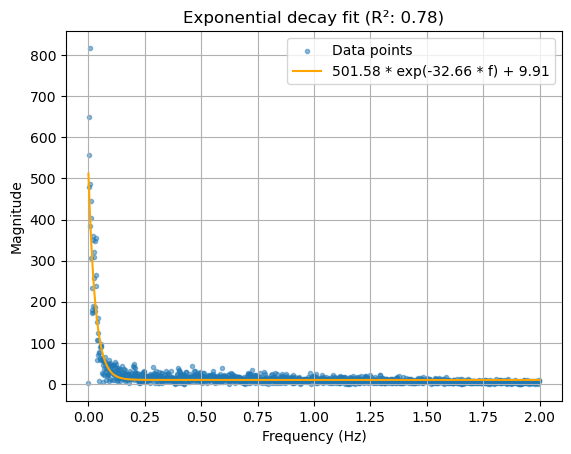

In [7]:
neuron_idx = 7
plt.scatter(fft_freqs_np[:], magnitude_spectrum[:, neuron_idx], marker='.', label='Data points', alpha=0.5)
fit_label = '{} * exp(-{} * f) + {}'.format(round(fit_params[neuron_idx, 0], 2), round(fit_params[neuron_idx, 1], 2), round(fit_params[neuron_idx, 2], 2))
plt.plot(fft_freqs_np[:], exponential_fits[:, neuron_idx], color='orange', label=fit_label)
plt.title('Exponential decay fit (R²: {})'.format(round(fit_quality[neuron_idx], 2)))
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.legend()
plt.grid(True)
plt.show()

In [8]:
import numpy as np
import scipy.fftpack as fft

def synthesize_time_series(exponential_fits, time_steps, random_seed=42):
    """Create a synthetic time series given a power spectrum."""
    # Set a random seed for reproducibility, if provided
    if random_seed is not None:
        np.random.seed(random_seed)

    num_freqs = exponential_fits.shape[0]
    synthetic_data = np.zeros((time_steps, exponential_fits.shape[1]))

    for i in range(synthetic_data.shape[1]):
        # Generate a random phase spectrum
        phase_spectrum = np.random.normal(0.0, 1.8, num_freqs) # let's fix sigma to 1.8 for now
        # Combine the power and phase spectra
        freq_domain_signal = exponential_fits[:, i] * np.exp(1j * phase_spectrum)
        # Perform the inverse Fourier transform to get the time series
        synthetic_data[:, i] = fft.ifft(freq_domain_signal, n=time_steps).real

    return synthetic_data

In [9]:
synthetic_data = synthesize_time_series(exponential_fits, dataset['worm0']['calcium_data'].shape[0], random_seed=42)

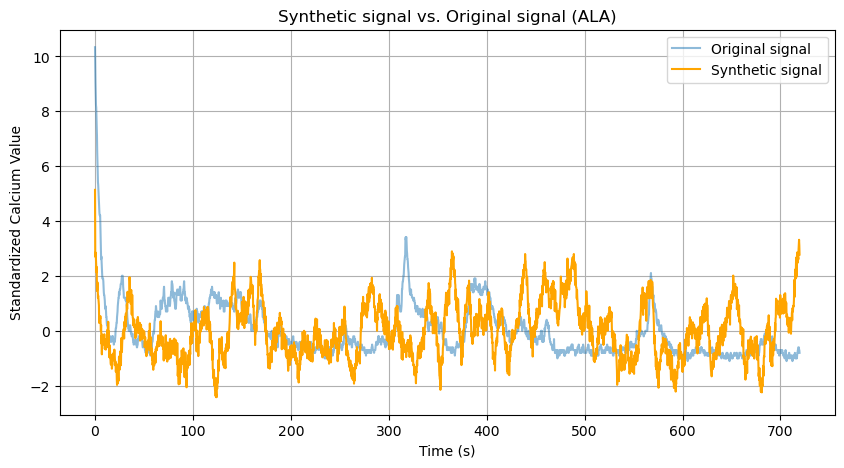

In [10]:
# Scale the synthetic data and original data with min_max scaling along dimension 0
from sklearn.preprocessing import MinMaxScaler, StandardScaler

scaler = StandardScaler()
synthetic_data = scaler.fit_transform(synthetic_data)
dataset['worm0']['calcium_data'] = scaler.fit_transform(dataset['worm0']['calcium_data'])

calcium_data = dataset['worm0']['calcium_data']
mask = dataset['worm0']['named_neurons_mask']
data = calcium_data[:, mask]

time_steps = data.shape[0]
time_vec = np.arange(time_steps) * 0.25

# Plot the synthetic data and original data
idx = 2
neuron_idx = np.where(dataset['worm0']['named_neurons_mask'] == True)[0][idx]
plt.figure(figsize=(10, 5))
plt.plot(time_vec, data[:, idx], label='Original signal', alpha=0.5)
plt.plot(time_vec, synthetic_data[:, idx], color='orange', label='Synthetic signal')
plt.legend()
plt.title("Synthetic signal vs. Original signal ({})".format(dataset['worm0']['slot_to_named_neuron'][neuron_idx]))
plt.xlabel("Time (s)")
plt.ylabel("Standardized Calcium Value")
plt.grid(True)
plt.show()

## Simple fft dataset

In [11]:
dataset = get_dataset(OmegaConf.create({'dataset': {'name': 'Kato2015'}}))

synthetic_data_list = []

for i in range(10):
    fft_freqs_np, magnitude_spectrum, phase_spectrum, exponential_fits, fit_params, fit_quality = approximate_exponential_decay(dataset['worm'+str(i)])
    synthetic_data_list.append(synthesize_time_series(exponential_fits, dataset['worm0']['calcium_data'].shape[0], random_seed=42))

Chosen dataset(s): ['Kato2015']
Num. worms: 12



In [12]:
synthetic_data_302 = np.zeros((2879, 302))

cols_tot = -1

for syn_data in synthetic_data_list:
    num_cols = syn_data.shape[1]
    for i in range(num_cols):
        synthetic_data_302[:, cols_tot+1] = syn_data[:, i]
        cols_tot += 1
        if cols_tot == 301:
            break
    if cols_tot == 301:
        break


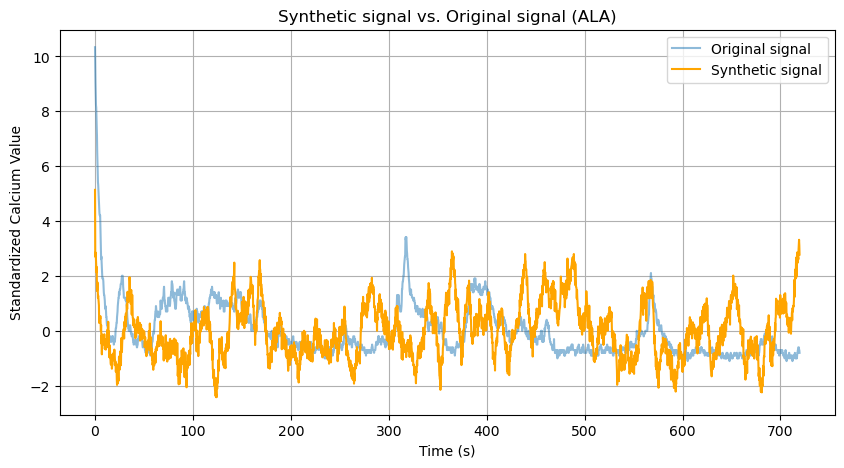

In [13]:
# Scale the synthetic data and original data with min_max scaling along dimension 0
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
synthetic_data_302 = scaler.fit_transform(synthetic_data_302)
dataset['worm0']['calcium_data'] = scaler.fit_transform(dataset['worm0']['calcium_data'])

calcium_data = dataset['worm0']['calcium_data']
mask = dataset['worm0']['named_neurons_mask']
data = calcium_data[:, mask]

time_steps = data.shape[0]
time_vec = np.arange(time_steps) * 0.25

# Plot the synthetic data and original data
idx = 2
neuron_idx = np.where(dataset['worm0']['named_neurons_mask'] == True)[0][idx]
plt.figure(figsize=(10, 5))
plt.plot(time_vec, data[:, idx], label='Original signal', alpha=0.5)
plt.plot(time_vec, synthetic_data_302[:, idx], color='orange', label='Synthetic signal')
plt.legend()
plt.title("Synthetic signal vs. Original signal ({})".format(dataset['worm0']['slot_to_named_neuron'][neuron_idx]))
plt.xlabel("Time (s)")
plt.ylabel("Standardized Calcium Value")
plt.grid(True)
plt.show()

In [18]:
from tests.leandro.plots import *

In [30]:
neuron_idx = np.where(dataset['worm0']['named_neurons_mask'] == True)[0][:10].tolist()

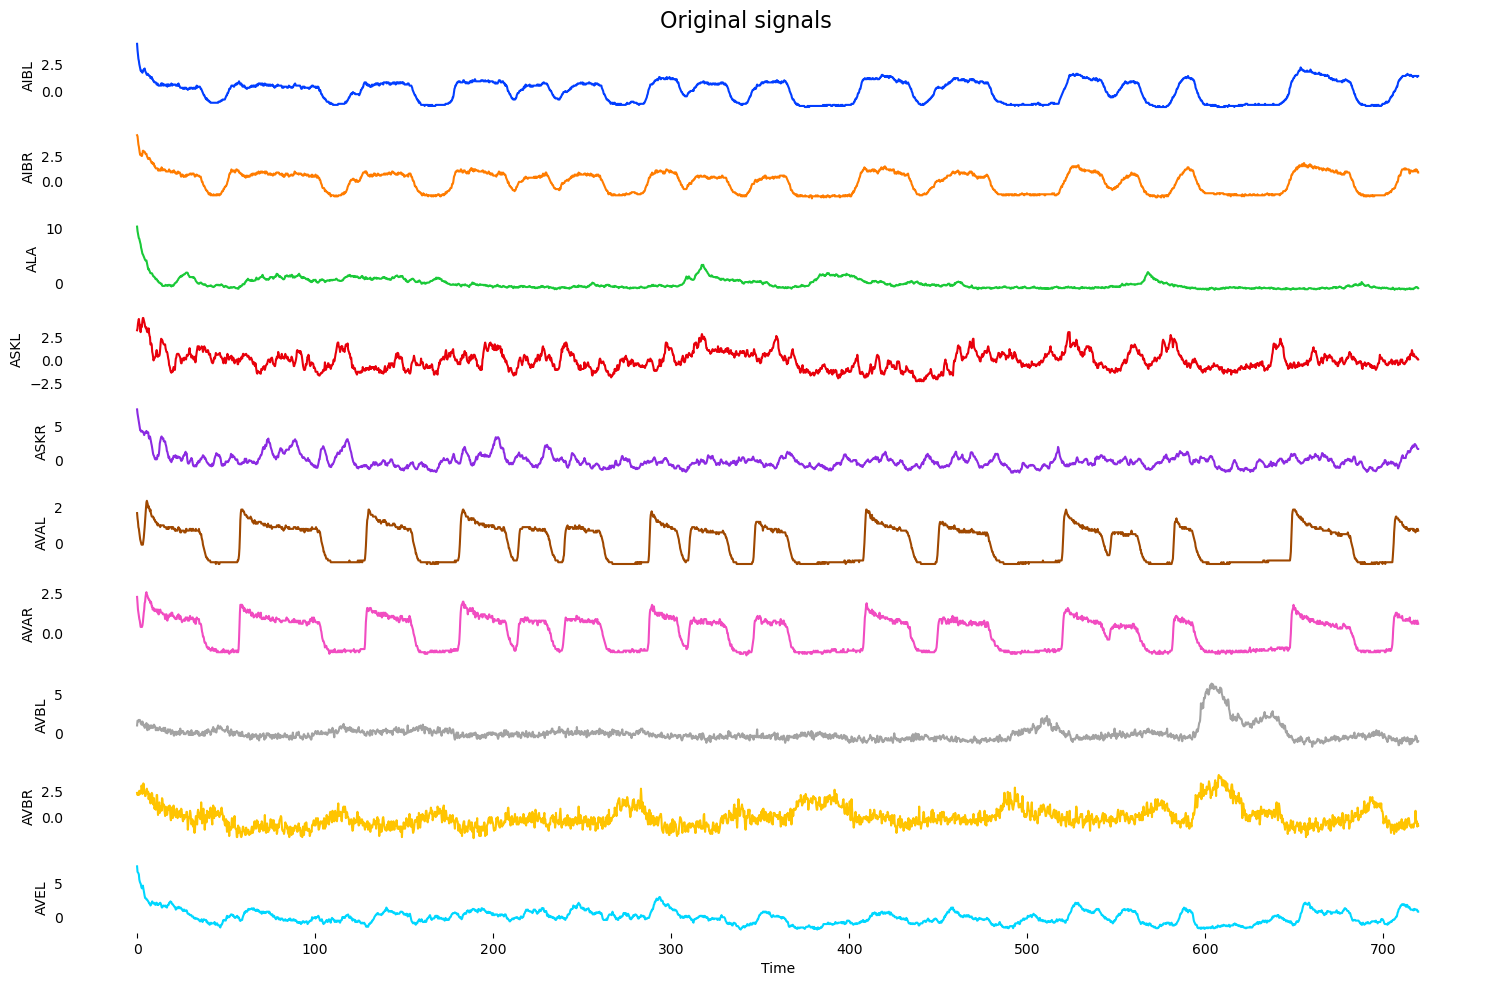

In [31]:
plot_signals(torch.from_numpy(dataset['worm0']['calcium_data']), torch.from_numpy(time_vec), neuron_idx=neuron_idx, yax_limit=False, suptitle='Original signals')

In [35]:
data_to_plot = np.zeros_like(synthetic_data_302)
data_to_plot[:, neuron_idx] = synthetic_data_302[:, :10]

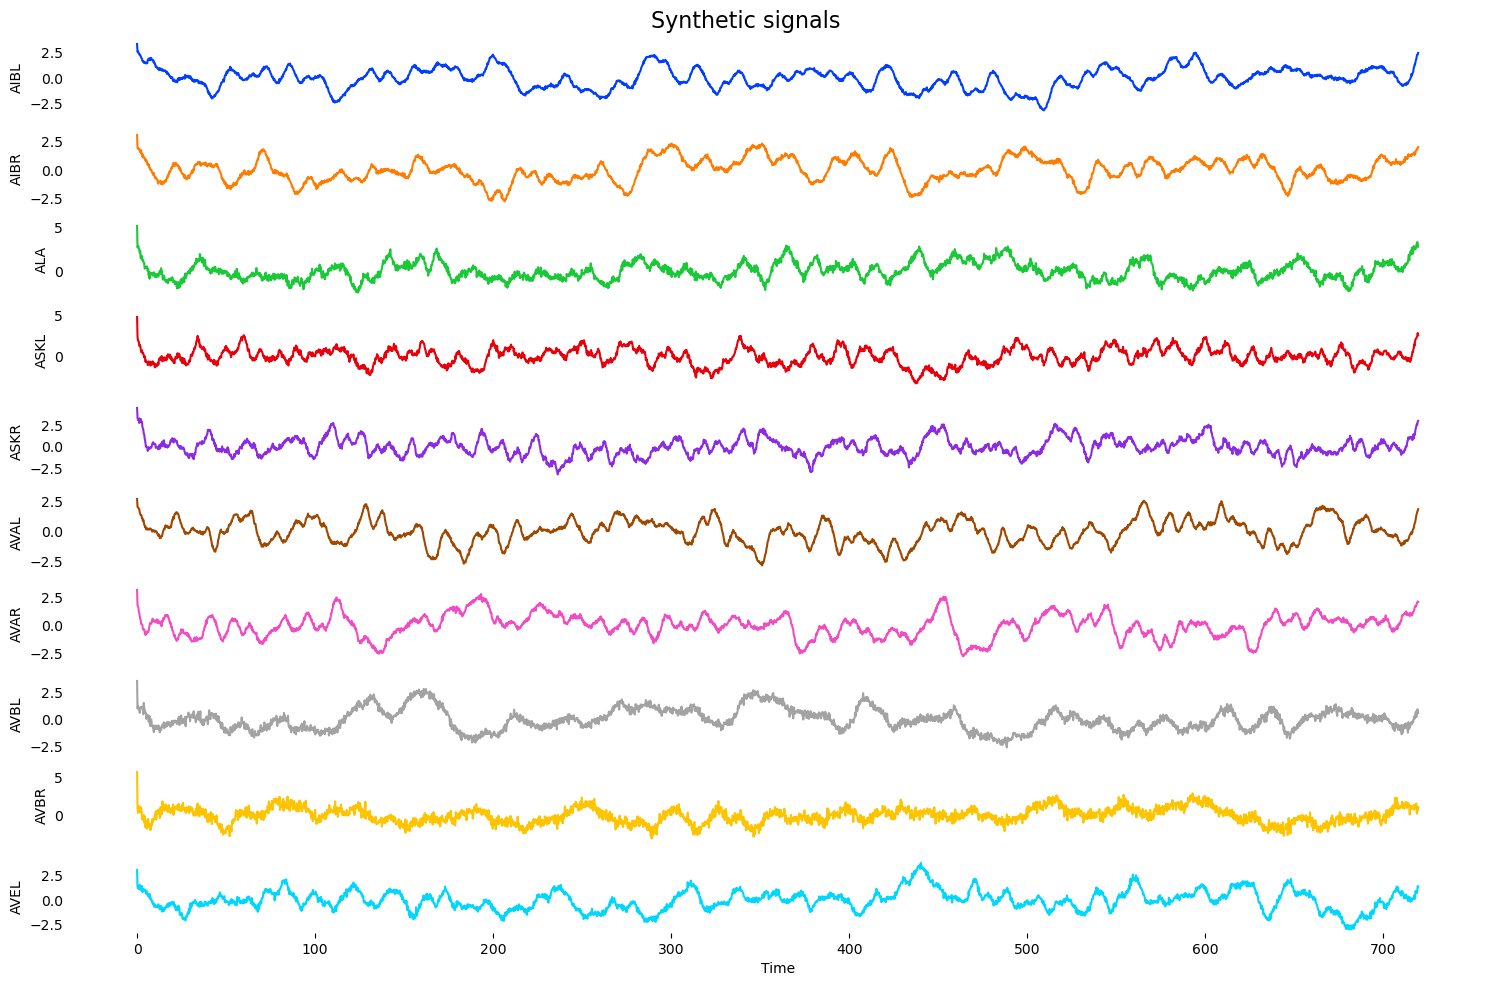

In [43]:
plot_signals(torch.from_numpy(data_to_plot), torch.from_numpy(time_vec), neuron_idx=neuron_idx, yax_limit=False, suptitle='Synthetic signals')

## Phase distribution

In [44]:
dataset = get_dataset(OmegaConf.load("../conf/dataset.yaml"))

Chosen dataset(s): ['Kato2015']
Num. worms: 12



In [45]:
fft_freqs_np, magnitude_spectrum, phase_spectrum, exponential_fits, fit_params, fit_quality = approximate_exponential_decay(dataset['worm0'])

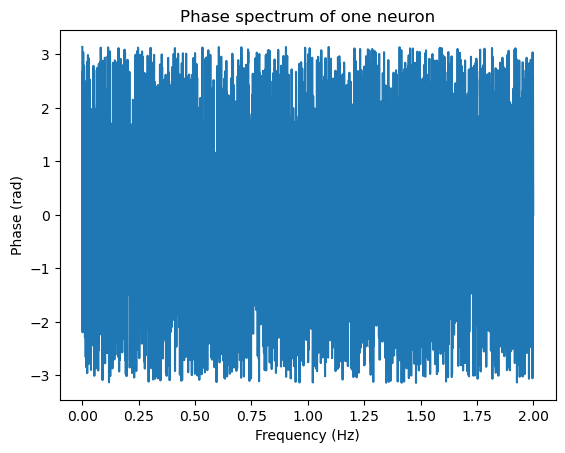

In [67]:
oneNeuronPhase = phase_spectrum[:, 0]
plt.plot(fft_freqs_np, oneNeuronPhase)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Phase (rad)')
plt.title('Phase spectrum of one neuron')
plt.show()

There's no evident relation between the phases and the frequency

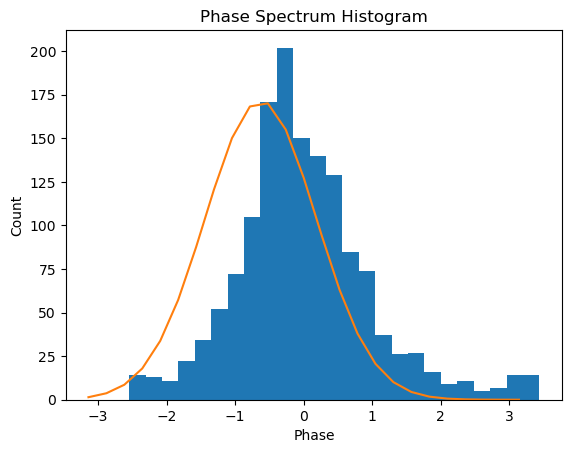

In [58]:
oneNeuronPhase = phase_spectrum[:, 0]

oneNeuronPhase = oneNeuronPhase - np.mean(oneNeuronPhase) # Remove the mean from the phase spectrum
oneNeuronPhase = oneNeuronPhase / np.std(oneNeuronPhase) # Normalize the phase spectrum

# Plot phase spectrum histogram
plt.hist(oneNeuronPhase, bins=25)
plt.xlabel("Phase")
plt.ylabel("Count")
plt.title("Phase Spectrum Histogram")

# Fit a Gaussian to the phase spectrum histogram
def gaussian(x, a, x0, sigma):
    return a * np.exp(-(x - x0) ** 2 / (2 * sigma ** 2))

popt, pcov = curve_fit(gaussian, np.linspace(-3.14, 3.14, num=25), np.histogram(oneNeuronPhase, bins=25)[0])

# Plot the Gaussian fit
plt.plot(np.linspace(-3.14, 3.14, num=25), gaussian(np.linspace(-3.14, 3.14, num=25), *popt))
plt.xlabel("Phase")
plt.ylabel("Count")
plt.title("Phase Spectrum Histogram")
plt.show()

The phases of a single neuron signal itself can't be approximated by a gaussian function (it fails the Shapiro-Wilk test).

But what about the mean of the neuron phases? Do they follow a gaussian distribution?

In [79]:
# Pipeline for phase distribution: compute the mean of the phases for each neuron of every individual

def distribution_params():

    dataset_names = ['Flavell2023', 'Kato2015', 'Nichols2017', 'Skora2018', 'Uzel2022', 'Kaplan2020']

    phase_distribution = np.zeros((143, 302, 2)) # (individual, neuron, (mu, std))
    exp_decay_params = np.zeros((143, 302, 3)) # (individual, neuron, (a, b, c))

    worm_count = 0

    for ds_name in dataset_names:
        # Load a single dataset
        dataset = get_dataset(OmegaConf.create({"dataset": {'name': ds_name}}))

        # Iterate over worms in the dataset
        for wormid, data in dataset.items():
            fft_freqs_np, magnitude_spectrum, phase_spectrum, exponential_fits, fit_params, fit_quality = approximate_exponential_decay(data)

            if (not fit_params is None) and (not phase_spectrum is None):
                for i, named_neuron in enumerate(data['slot_to_named_neuron']):

                    phase_distribution[worm_count, named_neuron, 0] = np.mean(phase_spectrum[:, i]) # mu
                    phase_distribution[worm_count, named_neuron, 1] = np.std(phase_spectrum[:, i]) # std

                    exp_decay_params[worm_count, named_neuron, 0] = fit_params[i, 0] # a
                    exp_decay_params[worm_count, named_neuron, 1] = fit_params[i, 1] # b
                    exp_decay_params[worm_count, named_neuron, 2] = fit_params[i, 2] # c

            worm_count += 1

    return phase_distribution, exp_decay_params

In [80]:
phase_distribution, exp_decay_params = distribution_params()

Chosen dataset(s): ['Flavell2023']
Num. worms: 50

Error - curve_fit failed
Chosen dataset(s): ['Kato2015']
Num. worms: 12

Chosen dataset(s): ['Nichols2017']
Num. worms: 44

Chosen dataset(s): ['Skora2018']
Num. worms: 12

Chosen dataset(s): ['Uzel2022']
Num. worms: 6

Chosen dataset(s): ['Kaplan2020']
Num. worms: 19



In [64]:
from scipy.stats import shapiro

test_counter = 0
gdist = 0

for i in range(302):
    neuron_phase_dist_mean = phase_distribution[:, i, 1]
    mask = np.where(neuron_phase_dist_mean != 0)[0]

    data_to_test = neuron_phase_dist_mean[mask]

    # test normality of the mean phase distribution
    if len(data_to_test) > 3:
        stat, p = shapiro(data_to_test)
        test_counter += 1
        print('Shapiro-Wilk test for normality for neuron {}: {}'.format(i, p>0.05)) # True if normal dist
        if p>0.05:
            gdist += 1

print('')
print(gdist/test_counter)

Shapiro-Wilk test for normality for neuron 0: True
Shapiro-Wilk test for normality for neuron 1: False
Shapiro-Wilk test for normality for neuron 2: False
Shapiro-Wilk test for normality for neuron 3: False
Shapiro-Wilk test for normality for neuron 6: False
Shapiro-Wilk test for normality for neuron 7: True
Shapiro-Wilk test for normality for neuron 8: False
Shapiro-Wilk test for normality for neuron 9: False
Shapiro-Wilk test for normality for neuron 10: True
Shapiro-Wilk test for normality for neuron 11: True
Shapiro-Wilk test for normality for neuron 12: False
Shapiro-Wilk test for normality for neuron 13: False
Shapiro-Wilk test for normality for neuron 14: False
Shapiro-Wilk test for normality for neuron 15: True
Shapiro-Wilk test for normality for neuron 16: False
Shapiro-Wilk test for normality for neuron 17: True
Shapiro-Wilk test for normality for neuron 18: False
Shapiro-Wilk test for normality for neuron 19: True
Shapiro-Wilk test for normality for neuron 20: False
Shapiro-

We don't have enough information to reject the hypothesis that the mean phase of 65% of the neurons follow a gaussian distribution!

=> hipothesis: all mean neuron phases can be approximated by a gaussian distribution

In [34]:
mean_phases_mean = phase_distribution[:, :, 0].mean(axis=0)
mean_phases_std = phase_distribution[:, :, 0].std(axis=0)

In [35]:
302 - np.count_nonzero(mean_phases_mean != 0)

85

We don't have data of 85 neurons!

=> We will conside the distribution of these neurons as a normal distribution with mean equal the of the (mean_phases_mean), and the std equal the mean of (mean_phases_std).

In [36]:
mask = np.where(mean_phases_mean == 0)[0] # missing values mask
mean_phases_mean[mask] = np.mean(mean_phases_mean[~mask])
mean_phases_std[mask] = np.mean(mean_phases_std[~mask])

In [ ]:
# Save the mean phase distribution
#np.save('mean_phase_distribution.npy', mean_phases_mean)
#np.save('mean_phase_distribution_std.npy', mean_phases_std)

## How to sample the magnitude distribution?
---

In [81]:
phase_distribution, exp_decay_params = distribution_params()

Chosen dataset(s): ['Flavell2023']
Num. worms: 50

Error - curve_fit failed
Chosen dataset(s): ['Kato2015']
Num. worms: 12

Chosen dataset(s): ['Nichols2017']
Num. worms: 44

Chosen dataset(s): ['Skora2018']
Num. worms: 12

Chosen dataset(s): ['Uzel2022']
Num. worms: 6

Chosen dataset(s): ['Kaplan2020']
Num. worms: 19



## Correlation between a and b?

In [102]:
# All a, b, c coefficients
a_coeff = exp_decay_params[:, :, 0].reshape(-1)
b_coeff = exp_decay_params[:, :, 1].reshape(-1)
c_coeff = exp_decay_params[:, :, 2].reshape(-1)

mask = np.where(a_coeff != 0)[0]

a_coeff = a_coeff[mask]
b_coeff = b_coeff[mask]
c_coeff = c_coeff[mask]

In [111]:
# Calculate the correlation coefficients
correlation_AB = np.corrcoef(a_coeff, b_coeff)[0, 1]
correlation_AC = np.corrcoef(a_coeff, c_coeff)[0, 1]
correlation_BC = np.corrcoef(b_coeff, c_coeff)[0, 1]

# Print the correlation coefficients
print("Correlation between A and B:", correlation_AB)
print("Correlation between A and C:", correlation_AC)
print("Correlation between B and C:", correlation_BC)


Correlation between A and B: 0.8544357413286214
Correlation between A and C: 0.10298655483173329
Correlation between B and C: 0.3286343696326075


-12.90175309163423


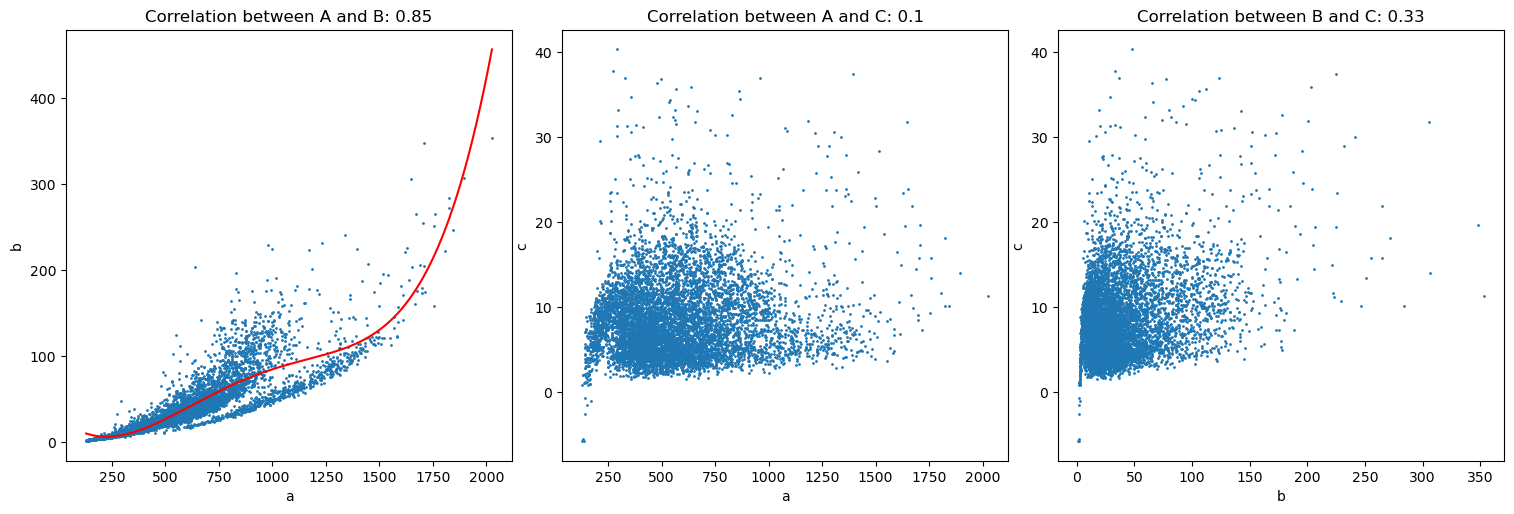

In [150]:
# Poly fit between a and b
fit_coefficients = np.polyfit(a_coeff, b_coeff, 5)
fit_curve = np.poly1d(fit_coefficients)
x = np.linspace(min(a_coeff), max(a_coeff), len(a_coeff))
y_pred = fit_curve(x)

# Compute the R-squared value
r_squared = r2_score(b_coeff, y_pred)
print(r_squared)

# Plot the correlation between AB, AC, BC in a subplot
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].scatter(a_coeff, b_coeff, s=1)
axs[0].plot(x, y_pred, color='red')
axs[0].set_xlabel('a')
axs[0].set_ylabel('b')
axs[0].set_title('Correlation between A and B: {}'.format(round(correlation_AB, 2)))

axs[1].scatter(a_coeff, c_coeff, s=1)
axs[1].set_xlabel('a')
axs[1].set_ylabel('c')
axs[1].set_title('Correlation between A and C: {}'.format(round(correlation_AC, 2)))

axs[2].scatter(b_coeff, c_coeff, s=1)
axs[2].set_xlabel('b')
axs[2].set_ylabel('c')
axs[2].set_title('Correlation between B and C: {}'.format(round(correlation_BC, 2)))

plt.tight_layout(pad=0.2)
plt.show()

## Neuron signature (a, b and c coefficients)

In [274]:
from scipy.stats import bootstrap
from scipy.stats import norm

def bootstrap_mean(data_array, confidence_level=0.9, random_state=None, ax=None, title=None):
    """Computes the bootstrap mean distribution of the given data.

    Parameters
    ----------
    data_array : array_like (1D)
        Input data. Samples must be in a sequence.
    confidence_level : float, optional
        Confidence level of the bootstrap distribution. Must be between 0 and 1.
    random_state : int, RandomState instance or None, optional
        Seed for the random number generator (if int), or numpy RandomState instance.

    Returns
    -------
    np.mean(res.bootstrap_distribution) : float
        Mean of the bootstrap distribution.
    res.standard_error : float
        Standard error of the bootstrap distribution.
    res.confidence_interval : tuple
        Confidence interval of the bootstrap distribution.
    """

    data = (data_array,)  # samples must be in a sequence
    rng = np.random.default_rng(random_state)
    res = bootstrap(data, np.mean, confidence_level=0.9, random_state=rng)

    if ax is not None:
        ax.hist(res.bootstrap_distribution, bins=25, density=True, alpha=0.75)
        ax.set_title('Bootstrap Mean Distribution (a coefficient)')
        ax.set_xlabel('Mean')
        ax.set_ylabel('PDF')

        # Draw vertical line on the mean
        ax.axvline(np.mean(res.bootstrap_distribution), color='black', linestyle='-.', alpha=0.5)

        # Plot a gaussian with mean and std of the bootstrap distribution
        x = np.linspace(min(res.bootstrap_distribution), max(res.bootstrap_distribution), len(res.bootstrap_distribution))
        y = norm.pdf(x, loc=np.mean(res.bootstrap_distribution), scale=res.standard_error)
        ax.plot(x, y, linestyle='-')

        # Shade inside the confidence intervals
        ax.fill_between(x, y, where=(x > res.confidence_interval[0]) & (x < res.confidence_interval[1]), alpha=0.5)

        # Shade outside the confidence intervals
        ax.fill_between(x, y, where=(x < res.confidence_interval[0]) | (x > res.confidence_interval[1]), alpha=0.5)

        if title is not None:
            ax.set_title(title)

        plt.tight_layout(pad=0.5)
        plt.grid(True)
        sns.set_style("whitegrid")

    return np.mean(res.bootstrap_distribution), res.standard_error, res.confidence_interval

In [282]:
# Create a log to save the prints when the neuron has no values
log = open('log.txt', 'w')

count_neurons_with_no_values = 0

a_coeffs = np.empty((2, len(NEURONS_302)))
b_coeffs = np.empty((2, len(NEURONS_302)))
c_coeffs = np.empty((2, len(NEURONS_302)))

for i, neuron_name in enumerate(NEURONS_302):

    mask = np.where(exp_decay_params[:, i, 0] !=0)[0] # neuron missing values mask
    a_coeff = exp_decay_params[:, i, 0][mask]
    b_coeff = exp_decay_params[:, i, 1][mask]
    c_coeff = exp_decay_params[:, i, 2][mask]

    if np.sum(exp_decay_params[:, i, 0][mask]) == 0:
        # Write in the log the neurons with no values
        log.write('Neuron {} has no values\n'.format(neuron_name))
        count_neurons_with_no_values += 1
    else:
        if len(a_coeff) <= 1:
            # Write in the log the neurons with only one value
            log.write('Neuron {} has only one value\n'.format(neuron_name))
            continue
        a_coeffs[0, i], a_coeffs[1, i], _ = bootstrap_mean(a_coeff) # mean, std
        b_coeffs[0, i], b_coeffs[1, i], _ = bootstrap_mean(b_coeff) # mean, std
        c_coeffs[0, i], c_coeffs[1, i], _ = bootstrap_mean(c_coeff) # mean, std

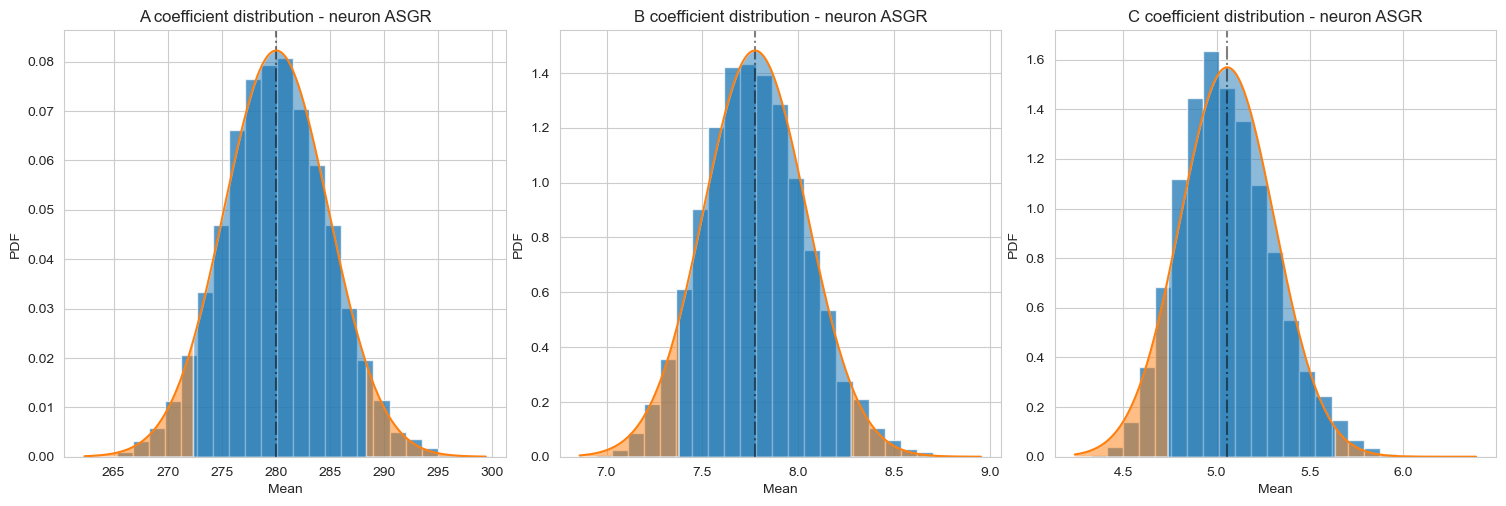

In [285]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

neuron_idx = 42
mask = np.where(exp_decay_params[:, neuron_idx, 0] !=0)[0] # neuron missing values mask
a_coeff = exp_decay_params[:, neuron_idx, 0][mask]
b_coeff = exp_decay_params[:, neuron_idx, 1][mask]
c_coeff = exp_decay_params[:, neuron_idx, 2][mask]

_ = bootstrap_mean(a_coeff, ax=axs[0], title='A coefficient distribution - neuron {}'.format(NEURONS_302[neuron_idx]))
_ = bootstrap_mean(b_coeff, ax=axs[1], title='B coefficient distribution - neuron {}'.format(NEURONS_302[neuron_idx]))
_ = bootstrap_mean(c_coeff, ax=axs[2], title='C coefficient distribution - neuron {}'.format(NEURONS_302[neuron_idx]))

In [98]:
a_avg = exp_decay_params[:, :, 0].mean(axis=0)
b_avg = exp_decay_params[:, :, 1].mean(axis=0)
c_avg = exp_decay_params[:, :, 2].mean(axis=0)

a_std = exp_decay_params[:, :, 0].std(axis=0)
b_std = exp_decay_params[:, :, 1].std(axis=0)
c_std = exp_decay_params[:, :, 2].std(axis=0)

In [101]:
# Replace missing values with the mean
mask = np.where(a_avg == 0)[0]
a_avg[mask] = np.mean(a_avg[~mask])
b_avg[mask] = np.mean(b_avg[~mask])
c_avg[mask] = np.mean(c_avg[~mask])

a_std[mask] = np.mean(a_std[~mask])
b_std[mask] = np.mean(b_std[~mask])
c_std[mask] = np.mean(c_std[~mask])

In [105]:
# Save the exponential decay parameters
np.save('exp_decay_params_a_avg.npy', a_avg)
np.save('exp_decay_params_b_avg.npy', b_avg)
np.save('exp_decay_params_c_avg.npy', c_avg)

np.save('exp_decay_params_a_std.npy', a_std)
np.save('exp_decay_params_b_std.npy', b_std)
np.save('exp_decay_params_c_std.npy', c_std)

In [118]:
np.save('exp_decay_params.npy', exp_decay_params)

## Sines

In [ ]:
import numpy as np
import pickle
import random
from sklearn.preprocessing import StandardScaler
from preprocess._utils import smooth_data_preprocess, reshape_calcium_data
from utils import NEURONS_302


def create_synthetic_dataset_sines(
    max_timesteps,
    num_worms=1,
    num_signal=302,
    num_named_neurons=302,
    if_noise=False,
    sum_frequencies=1,
    freq_gain=1.0,
    delta_seconds=0.10,
    noise_sd=0.01,
    transform=StandardScaler(),
    dataset_name="Synthetic0000",
):
    """
    Create synthetic worm datasets using a sum of sinusoidal functions.

    :param seq_len: The sequence length of the synthetic data.
    :param num_worms: The number of worms to create datasets for.
    :param num_signal: The number of signals, corresponds to number of neurons.
    :param num_named_neurons: The number of named neurons to create non-zero signals for.
    :param if_noise: If true, add Gaussian noise to the synthetic data.
    :param sum_frequencies: The number of sine functions to add together to create a signal.
    :param freq_gain: A multiplier for the frequencies of the calcium signal.
    :param delta_seconds: The constant time difference (in seconds) between each timepoint.
    :param transform: Standard deviation of the Gaussian noise.
    :param noise_sd: The sklearn transform to use for normalizing the data.
    :param dataset_name: The name to give the synthetic dataset.
    :return: A dictionary containing the synthetic worm datasets.
    """
    dataset = {}
    time_in_seconds = delta_seconds * np.arange(max_timesteps).reshape(
        -1, 1
    )  # Column vector

    # Create a memo of neurons to frequencies so that distinct neurons have distinct frequency signatures
    neuron_to_frequencies = dict()  # this will be consistent across worms

    # Create data for each worm
    for worm_idx in range(num_worms):
        # Create a memo of neurons to phases so that distinct neurons have distinct phase signatures
        neuron_to_phases = dict()  # this will vary across worms

        # Initialize worm data
        worm = f"worm{worm_idx}"
        worm_data = {}
        num_unknown_neurons = num_signal - num_named_neurons
        calcium_data = np.zeros((max_timesteps, num_signal))
        time_points = np.arange(max_timesteps)
        named_neuron_indices = random.sample(
            range(num_signal), num_named_neurons
        )  # random sampling without replacement
        named_neurons = set(NEURONS_302[i] for i in named_neuron_indices)

        # Create neuron to idx mapping and vice versa
        neuron_to_idx = {
            (neuron) if neuron in named_neurons else str(idx): idx
            for idx, neuron in enumerate(NEURONS_302)
        }
        idx_to_neuron = {idx: neuron for neuron, idx in neuron_to_idx.items()}

        # Create calcium data
        for i in named_neuron_indices:
            # TODO: Give each particular neuron a characteristic frequency that is consistent across worms
            neuron_name = NEURONS_302[i]
            frequencies = neuron_to_frequencies.setdefault(
                neuron_name,
                [
                    # freq_gain
                    # * np.random.uniform(
                    #     1.0 / max_timesteps, 10.0 / max_timesteps
                    # )  # random frequency
                    freq_gain * 4.0 / max_timesteps  # deterministic frequency
                    for _ in range(sum_frequencies)
                ],
            )
            phases = neuron_to_phases.setdefault(
                neuron_name,
                [
                    np.random.random() * 2 * np.pi  # random phase
                    # 0.5 * 2 * np.pi  # deterministic phase
                    for _ in range(sum_frequencies)
                ],
            )

            # Add sine functions
            for freq, phase in zip(frequencies, phases):
                calcium_data[:, i] += np.sin(2 * np.pi * freq * time_points + phase)

            # Add noise
            if if_noise:
                calcium_data[:, i] += np.random.normal(0, noise_sd, max_timesteps)

        # Normalize data
        calcium_data = transform.fit_transform(calcium_data)

        # Smooth the data
        smooth_method = "FFT"
        smooth_calcium_data = smooth_data_preprocess(
            calcium_data, time_in_seconds, smooth_method
        )
        dt = np.gradient(time_in_seconds, axis=0)
        dt[dt == 0] = np.finfo(float).eps
        original_dt = np.median(dt).item()
        resample_dt = delta_seconds
        residual_calcium = np.gradient(calcium_data, axis=0) / dt
        smooth_residual_calcium = smooth_data_preprocess(
            residual_calcium, time_in_seconds, smooth_method
        )

        # Save the data
        worm_data["dataset"] = dataset_name
        worm_data["smooth_method"] = smooth_method
        worm_data["worm"] = worm
        worm_data["calcium_data"] = calcium_data
        worm_data["residual_calcium"] = residual_calcium
        worm_data["smooth_calcium_data"] = smooth_calcium_data
        worm_data["smooth_residual_calcium"] = smooth_residual_calcium
        worm_data["time_in_seconds"] = time_in_seconds
        worm_data["dt"] = dt
        worm_data["original_median_dt"] = original_dt
        worm_data["resample_median_dt"] = resample_dt
        worm_data["max_timesteps"] = max_timesteps
        worm_data["neuron_to_idx"] = neuron_to_idx
        worm_data["idx_to_neuron"] = idx_to_neuron
        worm_data["num_neurons"] = num_signal
        worm_data["num_named_neurons"] = num_named_neurons
        worm_data["num_unknown_neurons"] = num_unknown_neurons

        worm_data = reshape_calcium_data(worm_data)

        dataset[worm] = worm_data

    return dataset


def save_synthetic_dataset(file_name, datasets):
    with open(file_name, "wb") as f:
        pickle.dump(datasets, f)


max_timesteps = 3000
num_worms = 12
num_signal = 302
num_named_neurons = 302
file_name = "Synthetic0000_sines"

# Creating and saving datasets
dataset = create_synthetic_dataset_sines(
    max_timesteps,
    num_worms,
    num_signal,
    num_named_neurons,
    if_noise=False,
    sum_frequencies=1,
    freq_gain=1.0,
    delta_seconds=0.25,
    noise_sd=0.00,
    transform=StandardScaler(),
    dataset_name=file_name,
)
save_synthetic_dataset(f"../data/processed/neural/{file_name}.pickle", dataset)

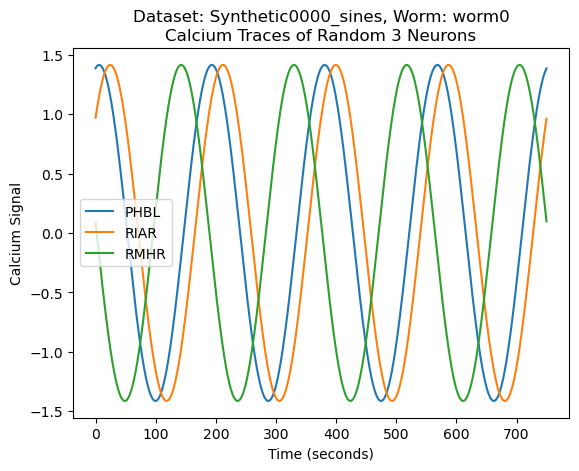

In [ ]:
import pickle
from visualize._utils import plot_worm_data

# Load synthetic dataset
with open(f"../data/processed/neural/{file_name}.pickle", "rb") as f:
    dataset = pickle.load(f)

# Plot the first few calcium traces for the first worm
plot_worm_data(dataset["worm0"], num_neurons=3, smooth=False)

## FFT

In [134]:
exp_decay_params = np.load('/home/lrvnc/Projects/worm-graph/data/exp_decay_params.npy')
random_individual = np.random.choice(np.arange(exp_decay_params.shape[0]), 1)[0]
params = exp_decay_params[random_individual,:,:]

mask = np.where(params != 0.0)[0]
params = params[mask,:]
random_neuron = np.random.choice(np.arange(params.shape[0]), 1)[0]
random_neuron

52

In [143]:
def decaying_exp(x, a, b, c):
    return a * np.exp(-b * x) + c

def synthesize_time_series(time_steps, dt, random_seed=42):
    """Create a synthetic time series given a power spectrum."""
    # Set a random seed for reproducibility, if provided
    if random_seed is not None:
        np.random.seed(random_seed)

    if time_steps % 2 == 0: # even
        num_freqs = int(time_steps / 2) + 1
    else: # odd
        num_freqs = int((time_steps + 1) / 2)

    # Load magnitude spectrum params
    exp_decay_params = np.load('/home/lrvnc/Projects/worm-graph/data/exp_decay_params.npy')

    exponential_fits = np.zeros((num_freqs, 302))

    for col in range(302):
        random_individual = np.random.choice(np.arange(exp_decay_params.shape[0]), 1)[0]
        params = exp_decay_params[random_individual, :, :]
        mask = np.where(params != 0.0)[0]
        params = params[mask,:]
        random_neuron = np.random.choice(np.arange(params.shape[0]), 1)[0]
        # Sample a, b, c from a normal distribution
        a = params[random_neuron, 0]
        b = params[random_neuron, 1]
        c = params[random_neuron, 2]
        exponential_fits[:, col] = decaying_exp(np.arange(num_freqs)*dt, a, b, c)

    synthetic_data = np.zeros((time_steps+10, exponential_fits.shape[1]))

    for i in range(synthetic_data.shape[1]):
        # Generate a random phase spectrum
        phase_spectrum = np.random.normal(0.0, 1.8, num_freqs) # let's fix sigma to 1.8 for now
        # Combine the power and phase spectra
        freq_domain_signal = exponential_fits[:, i] * np.exp(1j * phase_spectrum)
        # Perform the inverse Fourier transform to get the time series
        synthetic_data[:, i] = fft.ifft(freq_domain_signal, n=time_steps+10).real

    return synthetic_data[10:,:], exponential_fits

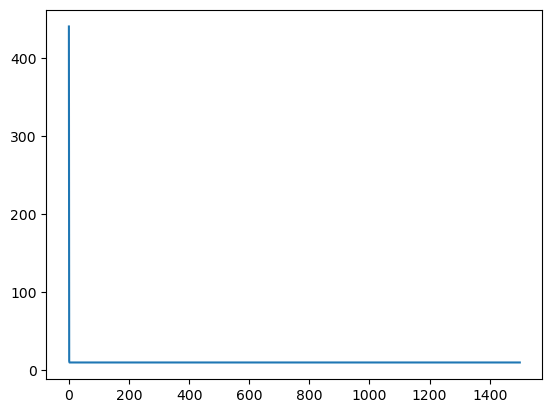

In [146]:
plt.plot(exp_fits[:, 7])

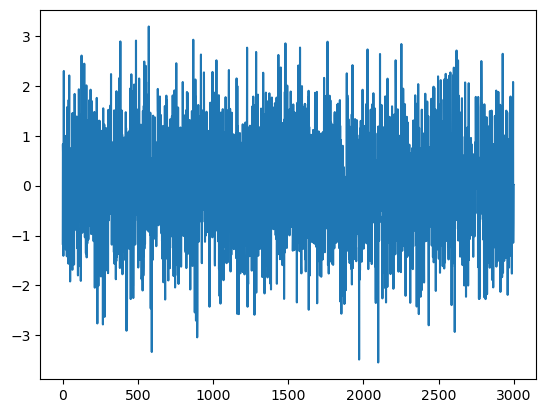

In [148]:
synthetic_data, exp_fits = synthesize_time_series(3000, 0.25, random_seed=42)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
synthetic_data = scaler.fit_transform(synthetic_data)
plt.plot(synthetic_data[:, 100])

In [ ]:
import numpy as np
import pickle
import random
from sklearn.preprocessing import StandardScaler
from preprocess._utils import smooth_data_preprocess, reshape_calcium_data
from utils import NEURONS_302


def create_synthetic_dataset_sines(
    max_timesteps,
    num_worms=1,
    num_signal=302,
    num_named_neurons=302,
    if_noise=False,
    sum_frequencies=1,
    freq_gain=1.0,
    delta_seconds=0.10,
    noise_sd=0.01,
    transform=StandardScaler(),
    dataset_name="Synthetic0000",
):
    """
    Create synthetic worm datasets using a sum of sinusoidal functions.

    :param seq_len: The sequence length of the synthetic data.
    :param num_worms: The number of worms to create datasets for.
    :param num_signal: The number of signals, corresponds to number of neurons.
    :param num_named_neurons: The number of named neurons to create non-zero signals for.
    :param if_noise: If true, add Gaussian noise to the synthetic data.
    :param sum_frequencies: The number of sine functions to add together to create a signal.
    :param freq_gain: A multiplier for the frequencies of the calcium signal.
    :param delta_seconds: The constant time difference (in seconds) between each timepoint.
    :param transform: Standard deviation of the Gaussian noise.
    :param noise_sd: The sklearn transform to use for normalizing the data.
    :param dataset_name: The name to give the synthetic dataset.
    :return: A dictionary containing the synthetic worm datasets.
    """
    dataset = {}
    time_in_seconds = delta_seconds * np.arange(max_timesteps).reshape(
        -1, 1
    )  # Column vector

    # Create a memo of neurons to frequencies so that distinct neurons have distinct frequency signatures
    neuron_to_frequencies = dict()  # this will be consistent across worms

    # Create data for each worm
    for worm_idx in range(num_worms):
        # Create a memo of neurons to phases so that distinct neurons have distinct phase signatures
        neuron_to_phases = dict()  # this will vary across worms

        # Initialize worm data
        worm = f"worm{worm_idx}"
        worm_data = {}
        num_unknown_neurons = num_signal - num_named_neurons
        calcium_data = np.zeros((max_timesteps, num_signal))
        time_points = np.arange(max_timesteps)
        named_neuron_indices = random.sample(
            range(num_signal), num_named_neurons
        )  # random sampling without replacement
        named_neurons = set(NEURONS_302[i] for i in named_neuron_indices)

        # Create neuron to idx mapping and vice versa
        neuron_to_idx = {
            (neuron) if neuron in named_neurons else str(idx): idx
            for idx, neuron in enumerate(NEURONS_302)
        }
        idx_to_neuron = {idx: neuron for neuron, idx in neuron_to_idx.items()}

        # Create calcium data
        for i in named_neuron_indices:
            # TODO: Give each particular neuron a characteristic frequency that is consistent across worms
            neuron_name = NEURONS_302[i]
            frequencies = neuron_to_frequencies.setdefault(
                neuron_name,
                [
                    # freq_gain
                    # * np.random.uniform(
                    #     1.0 / max_timesteps, 10.0 / max_timesteps
                    # )  # random frequency
                    freq_gain * 4.0 / max_timesteps  # deterministic frequency
                    for _ in range(sum_frequencies)
                ],
            )
            phases = neuron_to_phases.setdefault(
                neuron_name,
                [
                    np.random.random() * 2 * np.pi  # random phase
                    # 0.5 * 2 * np.pi  # deterministic phase
                    for _ in range(sum_frequencies)
                ],
            )

            # Add sine functions
            for freq, phase in zip(frequencies, phases):
                calcium_data[:, i] += np.sin(2 * np.pi * freq * time_points + phase)

            # Add noise
            if if_noise:
                calcium_data[:, i] += np.random.normal(0, noise_sd, max_timesteps)

        # Normalize data
        calcium_data = transform.fit_transform(calcium_data)

        # Smooth the data
        smooth_method = "FFT"
        smooth_calcium_data = smooth_data_preprocess(
            calcium_data, time_in_seconds, smooth_method
        )
        dt = np.gradient(time_in_seconds, axis=0)
        dt[dt == 0] = np.finfo(float).eps
        original_dt = np.median(dt).item()
        resample_dt = delta_seconds
        residual_calcium = np.gradient(calcium_data, axis=0) / dt
        smooth_residual_calcium = smooth_data_preprocess(
            residual_calcium, time_in_seconds, smooth_method
        )

        # Save the data
        worm_data["dataset"] = dataset_name
        worm_data["smooth_method"] = smooth_method
        worm_data["worm"] = worm
        worm_data["calcium_data"] = calcium_data
        worm_data["residual_calcium"] = residual_calcium
        worm_data["smooth_calcium_data"] = smooth_calcium_data
        worm_data["smooth_residual_calcium"] = smooth_residual_calcium
        worm_data["time_in_seconds"] = time_in_seconds
        worm_data["dt"] = dt
        worm_data["original_median_dt"] = original_dt
        worm_data["resample_median_dt"] = resample_dt
        worm_data["max_timesteps"] = max_timesteps
        worm_data["neuron_to_idx"] = neuron_to_idx
        worm_data["idx_to_neuron"] = idx_to_neuron
        worm_data["num_neurons"] = num_signal
        worm_data["num_named_neurons"] = num_named_neurons
        worm_data["num_unknown_neurons"] = num_unknown_neurons

        worm_data = reshape_calcium_data(worm_data)

        dataset[worm] = worm_data

    return dataset


def save_synthetic_dataset(file_name, datasets):
    with open(file_name, "wb") as f:
        pickle.dump(datasets, f)


max_timesteps = 3000
num_worms = 12
num_signal = 302
num_named_neurons = 302
file_name = "Synthetic0000_sines"

# Creating and saving datasets
dataset = create_synthetic_dataset_sines(
    max_timesteps,
    num_worms,
    num_signal,
    num_named_neurons,
    if_noise=False,
    sum_frequencies=1,
    freq_gain=1.0,
    delta_seconds=0.25,
    noise_sd=0.00,
    transform=StandardScaler(),
    dataset_name=file_name,
)
save_synthetic_dataset(f"../data/processed/neural/{file_name}.pickle", dataset)